# Customer churn analysis

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import *

import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import seaborn as sns
from config import snowflake_conn_prop

/Users/yjlee/.conda/envs/snowpark-python/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql("select current_warehouse(), current_database(), current_schema()").collect())

[Row(CURRENT_WAREHOUSE()='TEST_WH', CURRENT_DATABASE()='SNOWPARK_QUICKSTART', CURRENT_SCHEMA()='TELCO')]


In [3]:
%%time
raw = session.table('TRAIN_DATASET').sample(n=20000)
data = raw.toPandas()

CPU times: user 787 ms, sys: 52.9 ms, total: 840 ms
Wall time: 6.26 s


## Check distribution

In [6]:
(unique, counts) = np.unique(data['CHURNVALUE'], return_counts=True)
print('Unique value of target variables : ', unique)
print('Count of target variable: ', counts)

Unique value of target variables :  [0. 1.]
Count of target variable:  [13595  6405]


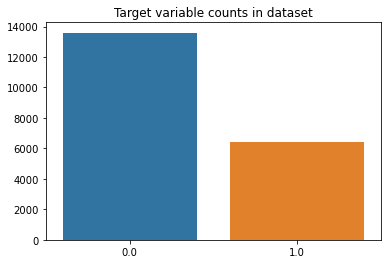

In [7]:
sns.barplot(x=unique, y=counts)
plt.title("Target variable counts in dataset")
plt.show()

## Define explonatory variables and target variables

In [8]:
data.head()

,CUSTOMERID,COUNT,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENUREMONTHS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
0,3461-TcVuF,1,Female,False,True,False,70,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,false,Credit card (automatic),86.45,5950.20,0.0
1,4323-Nirma,1,Female,True,True,False,32,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,true,Credit card (automatic),85.95,2628.60,1.0
2,4382-3o3PN,1,Female,False,False,False,3,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Electronic check,20.20,65.95,0.0
3,8943-lra2R,1,Female,False,False,False,10,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Mailed check,18.85,163.20,0.0
4,2935-QKbeW,1,Male,False,True,True,68,No,No phone service,DSL,Yes,Yes,No,No,Yes,No,One year,false,Mailed check,44.80,2983.65,0.0


In [16]:
categorical = [var for var in data.columns if ((data[var].dtype == 'O') or (data[var].dtype == 'bool'))]
categorical.pop(0)
print(categorical)

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']


In [17]:
numerical = [var for var in data.columns if var not in categorical and var != 'CHURNVALUE' and 'CUSTOMERID' not in var]
print(numerical)

['COUNT', 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']


   COUNT  TENUREMONTHS  MONTHLYCHARGES  TOTALCHARGES
0      1            70           86.45       5950.20
1      1            32           85.95       2628.60
2      1             3           20.20         65.95
3      1            10           18.85        163.20
4      1            68           44.80       2983.65


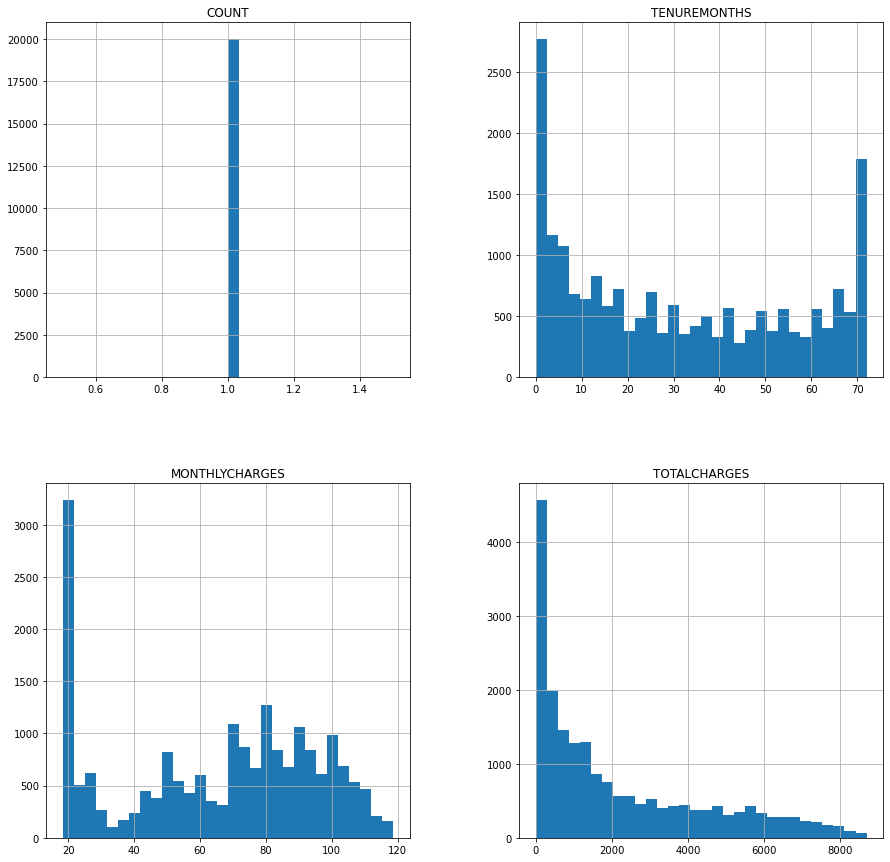

In [18]:
print(data[numerical].head())
data[numerical].hist(bins=30, figsize=(15,15))
plt.show()

## Missing values

In [19]:
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]
data[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

## Numerical variables

In [20]:
print('Number of numerical variables: ', len(numerical))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_df = data[numerical]
scaler.fit(num_df, y=None)

num_df.head()

Number of numerical variables:  4


,COUNT,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES
0,1,70,86.45,5950.20
1,1,32,85.95,2628.60
2,1,3,20.20,65.95
3,1,10,18.85,163.20
4,1,68,44.80,2983.65


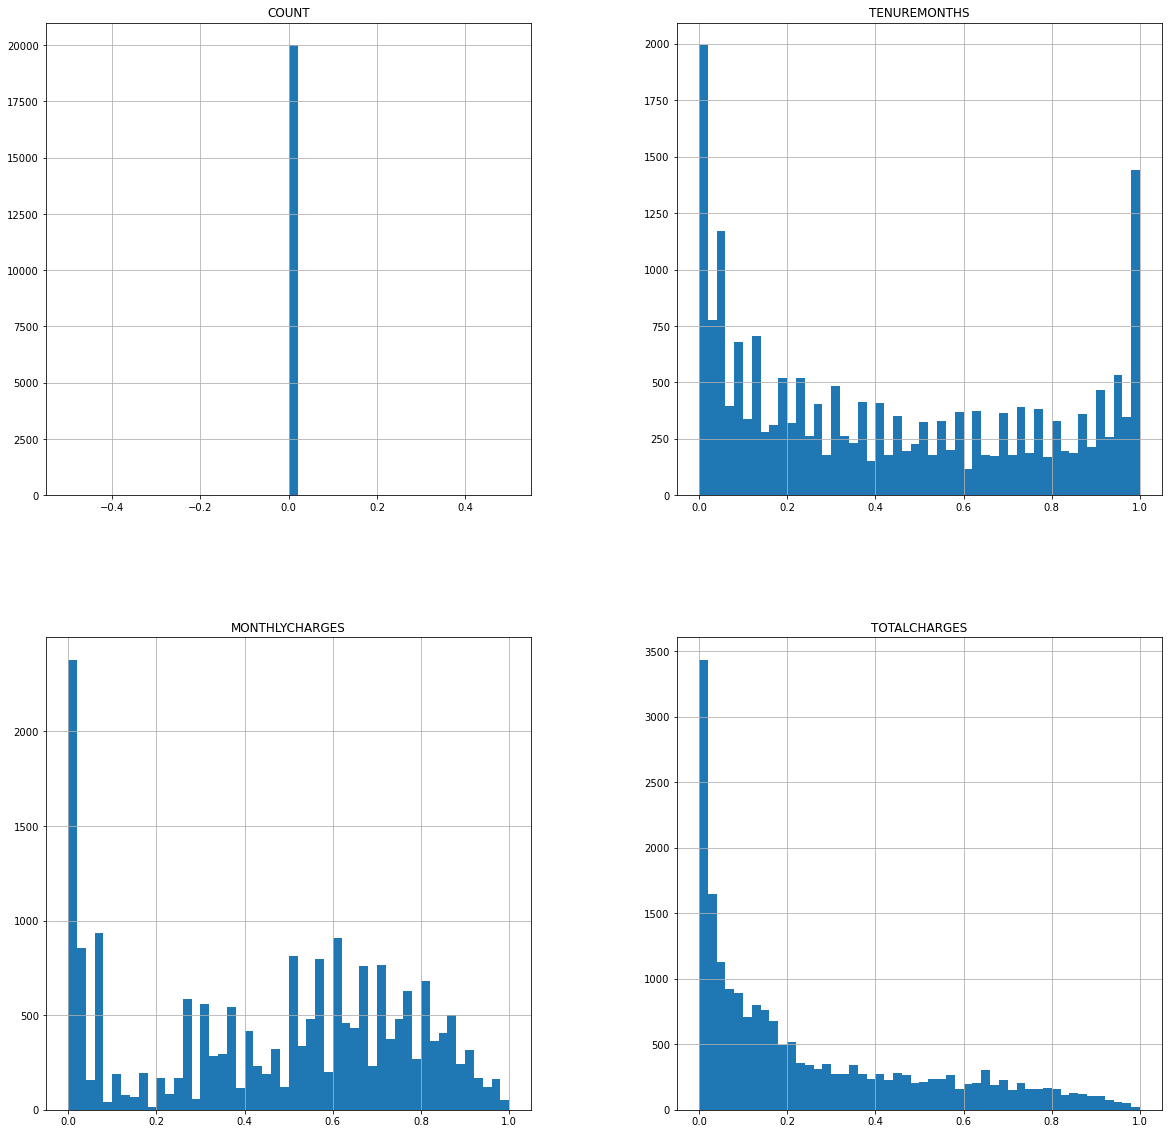

In [21]:
new_df = pd.DataFrame(scaler.transform(num_df), columns=data[numerical].columns)
new_df.head()
new_df.hist(bins=50, figsize=(20,20))
plt.show()

### Remove Outliers

In [29]:
def drop_outliers(df, out_name):
    iqr = 1.5 * (np.percentile(df[out_name], 75) - np.percentile(df[out_name], 25))
    df.drop(df[df[out_name] > (iqr + np.percentile(df[out_name], 75))].index, inplace=True)
    df.drop(df[df[out_name] < (np.percentile(df[out_name], 25) - iqr)].index, inplace=True)

drop_outliers(data,'TENUREMONTHS')
drop_outliers(data,'MONTHLYCHARGES')
drop_outliers(data,'TOTALCHARGES')

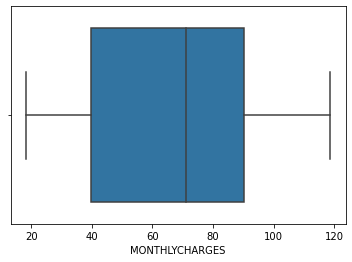

In [30]:
sns.boxplot(x=data["MONTHLYCHARGES"])
plt.show()

## Categorical variables

## 

In [31]:
print('Number of categorical variables: ', len(categorical))

Number of categorical variables:  16


In [32]:
data[categorical].head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD
0,Female,False,True,False,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,false,Credit card (automatic)
1,Female,True,True,False,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,true,Credit card (automatic)
2,Female,False,False,False,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Electronic check
3,Female,False,False,False,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Mailed check
4,Male,False,True,True,No,No phone service,DSL,Yes,Yes,No,No,Yes,No,One year,false,Mailed check


### Number of labels: cardinality

<AxesSubplot:>

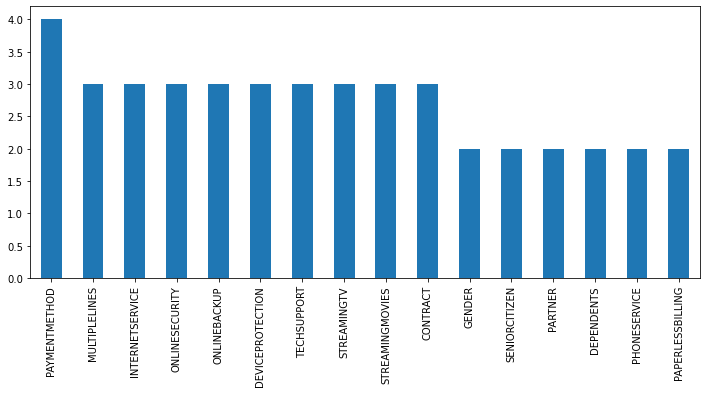

In [33]:
data[categorical].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

### Rare labels

In [35]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()
    tmp = df.groupby(var)['CHURNVALUE'].count() / len(df)
    return tmp[tmp < rare_perc]

for var in categorical:
    print(analyse_rare_labels(data, var, 0.01))

Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)
Series([], Name: CHURNVALUE, dtype: float64)


In [36]:
data[categorical].shape, data[numerical].shape, data['CHURNVALUE'].shape

((19992, 16), (19992, 4), (19992,))

In [37]:
final_cols = categorical + numerical + ['CHURNVALUE']
final_cols

['GENDER',
 'SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'COUNT',
 'TENUREMONTHS',
 'MONTHLYCHARGES',
 'TOTALCHARGES',
 'CHURNVALUE']

In [38]:
%%time
snowpark_train_df = session.write_pandas(data[final_cols], 'TELCO_TRAIN_SET', auto_create_table=True)

CPU times: user 533 ms, sys: 33.5 ms, total: 567 ms
Wall time: 10.9 s


In [39]:
snowpark_train_df.toPandas()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,COUNT,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
0,Female,False,True,False,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,false,Credit card (automatic),1,70,86.45,5950.20,0.0
1,Female,True,True,False,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,true,Credit card (automatic),1,32,85.95,2628.60,1.0
2,Female,False,False,False,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Electronic check,1,3,20.20,65.95,0.0
3,Female,False,False,False,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,false,Mailed check,1,10,18.85,163.20,0.0
4,Male,False,True,True,No,No phone service,DSL,Yes,Yes,No,No,Yes,No,One year,false,Mailed check,1,68,44.80,2983.65,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19987,Male,False,True,True,Yes,Yes,DSL,Yes,Yes,No,No,No,Yes,Two year,false,Bank transfer (automatic),1,53,69.70,3686.05,0.0
19988,Male,False,True,False,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,true,Bank transfer (automatic),1,70,79.25,5731.85,0.0
19989,Female,False,True,False,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,true,Electronic check,1,65,105.50,6985.65,1.0
19990,Male,True,True,False,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,false,Electronic check,1,1,74.30,74.30,0.0


In [40]:
session.close()